# Example notebook for the Tube approach to find focusing terms
_B. Riemann, Nov 2020 -- Jul 2021_

This notebook enables one to read in 3d example fieldmaps on an equidistant grid, and to compute generalized multipole coefficients from them.

We start by importing the functions that we require (see comments on right side for explanations):

In [1]:
# ZyX is a mostly 2d submodule used to compute the trajectory in the first place
from ZyX.basic import rigidityFromMeV # to normalize magnetic fields in T to curvature, divide by rigidity
from ZyX import CurvatureFunction2D # the basic object for 2d tracking. It can use superpositions of several 2d curvature maps that are shifted and rotated against each other (superfluous functionality)
from ZyX.discrete import SplineMap  # a 2d grid of curvature points is taken as input to create a continous 2d curvature map using spline interpolation
from ZyX.gridtube import pqr_indices, regionpoints, genB, generateBasis, tubeSystemMatrix, plot_multipoles  # box of 3d grid helper functions specifically for the Grid-Tube algorithm

from numpy import zeros, zeros_like, absolute, asarray, hstack, empty, sum, meshgrid
from scipy.linalg import det, inv  # matrices and linear algebra
from matplotlib.pyplot import subplots, savefig

## read-in field data

To create the fieldmaps in the first place, run `python example_fieldmaps.py` once, before continuing this notebook.

Select one of four datasets in the next line:

In [2]:
dataset = 'sqa_quad'
allowed_names = ('pure_dipole', 'pure_quad', 'sqa_quad', 'sqa_dipole')
if dataset not in allowed_names:
    raise Exception(f'Please set dataset to one of {allowed_names}')

In [3]:
from numpy import load
def loadMagneticFieldMap(filename):
    """output units are mm for lengths and T for flux density"""
    data = load(filename)
    return data['xRng'], data['yRng'], data['zRng'], data['bFull']

select the example file you want to use here:

In [4]:
xRng, yRng, zRng, bFull = loadMagneticFieldMap(f'{dataset}.npz')
assert bFull.shape == (len(xRng), len(yRng), len(zRng), 3) # ranges match the 3d field data

## 2d trajectory in machine plane
We extract bY from the lowest slice (y=0) of the bFull cube and then feed it into the SplineMap

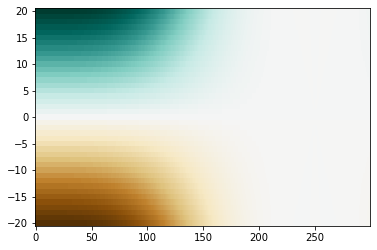

In [5]:
bY = bFull[:,0,:,1] # 0: index for y=0 (machine plane), 1: y-component of B
 # uncomment these two lines if you like to have a look at the 2d grid:
fig, ax = subplots() 
ax.pcolormesh(zRng, xRng, bY, shading='nearest', cmap='BrBG')

In [6]:
# be careful: in-place scaling of bY by rigidity occurs later in cf.addField(sm)
sm = SplineMap(zRng/1e3, xRng/1e3, bY.T) # SI units for Z and X
cf = CurvatureFunction2D(2700)
cf.addField(sm)  # sm is put in the CurvatureFunction container that can hold several map combinations. 

shapes: z=300, x=41, fld=(300, 41)


In [7]:
sDiff=1e-3
traj = cf.solveTrajectory(0.0, sMax=0.25, sDiff=sDiff) 
traj

orbit trajectory starting (Z=0.00e+00 m, X=0.00e+00 m) ending (Z=2.50e-01 m, X=3.68e-22 m) with -0.000 deg

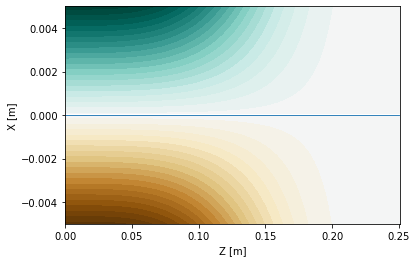

In [8]:
fig, ax = subplots()
cf.plot(ax, trajectories=[traj,])

In [9]:
fig.tight_layout()
fig.savefig(f'{dataset}_traj.pdf')

## 3d multipole extraction by Tube algorithm
the spatial coordinates used as input here are mm

In [10]:
xyzIn_mm = meshgrid(xRng, yRng, zRng, indexing='ij')
bFull /= rigidityFromMeV(2700)  # remember that bFull is still in [T], so we turn it into a curvature field [1/m]

- collect all points of the grid in the tube (allX,allY,allS); the tube is constructed as a series of thin cylinders
- rotate the curvature vectors (scaled magnetic field) into the system of the cylinder respectively the beam, (allBx,allBy)

In [11]:
allX = list()
allY = list()
allS = list()
allBx = list()
allBy = list()
h=500*sDiff # half height of sDiff, in mm
for n, sVal in enumerate(1e3*traj.s):
    xyzCenter = (1e3*traj.X[n], 0, 1e3*traj.Z[n])
    inRegion, xf, yf, zf = regionpoints(*xyzCenter, *xyzIn_mm, radius=9.5, theta=traj.cTheta[n], h=h, nopts_warn=False)
    bx, by = genB(bFull[inRegion], traj.cTheta[n], traj.curv[n])
    allX.extend(xf)
    allY.extend(yf)
    
    allBx.extend(bx)
    allBy.extend(by)
    
    zf += sVal
    allS.extend(zf)

allX = asarray(allX)
allY = asarray(allY)
allBxy = empty(2*len(allBx)) # stack allBx,allBy
allBxy[:len(allBx)] = allBx
allBxy[len(allBx):] = allBy
del allBx
del allBy
allS = asarray(allS)
print(f'{xyzIn_mm[0].shape=}, {allX.shape=}, {allY.shape=}')

xyzIn_mm[0].shape=(41, 11, 300), allX.shape=(39156,), allY.shape=(39156,)


### generate transverse basis functions for tube

the `pqr` list contains the allowed indices for p, q in the potentials x^p y^q (r is not used anymore). It is constrained for example by not allowing dipole (as trajectory curvature is later substracted) and by allowing only fields with machine plane symmetry

these are only transverse basis functions, they don't have any s dependence

In [12]:
pqr = pqr_indices()

In [13]:
constA = generateBasis(pqr, allX, allY, 0, skalfac=0.1)
constA.shape

(78312, 11)

### generate system matrix
Longitudinal basis functions (triangle functions) are multiplied with the `constA` transverse basis, forming the system matrix `bigA` for the linear system

    allBxy =   bigA  * bigC
    
where `bigC` holds the desired magnetic polynomial coefficients

In [14]:
bigA = tubeSystemMatrix(1e3*traj.s, 1e3*sDiff, constA, allS)
print(f'approx. matrix size is {bigA.size*4*1e-9:.2f} GB')
nonz=sum(bigA!=0)
print(f'{nonz} / {bigA.size} elements are nonzero ({nonz/bigA.size:.2e}), vs estimate {2/len(traj)=:.2e}')

approx. matrix size is 0.86 GB
1394680 / 216219432 elements are nonzero (6.45e-03), vs estimate 2/len(traj)=7.97e-03


In [15]:
from scipy.sparse.linalg import lsqr
print('solving system. this may take a few minutes')
res = lsqr(bigA, allBxy) # converts bigA to sparse form automatically
bigC = res[0]
if res[1]!=0:
    print(f'converged after {res[2]} iterations')
else:
    print(f'unsuccessful after {res[2]} iterations')

solving system. this may take a few minutes
converged after 8 iterations


In [16]:
from numpy import amax, sqrt
resid = allBxy - bigA @ bigC
resid = sqrt(resid[:len(allS)]**2 + resid[len(allS):]**2)
print(f'{amax(allBxy) = :.2e}, {amax(resid) = :.2e}')

amax(allBxy) = 1.78e-03, amax(resid) = 1.07e-12


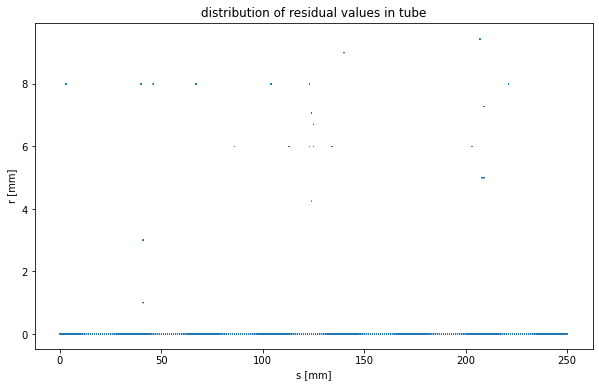

In [17]:
fig, ax = subplots(figsize=(10,6))
ax.scatter(allS, sqrt(allX**2 + allY**2), resid*1e3)
_ = ax.set(xlabel='s [mm]', ylabel='r [mm]', title='distribution of residual values in tube')

In [18]:
from numpy import copy
skalfac=100
coefs = copy(bigC.reshape(len(traj.s), len(pqr)).T)
for n, row in pqr.iterrows():
    coefs[n] *= skalfac**(row['order']-1)

[Text(0.5, 0, 's [m]'), Text(0.5, 0, 's [m]'), Text(0.5, 0, 's [m]')]

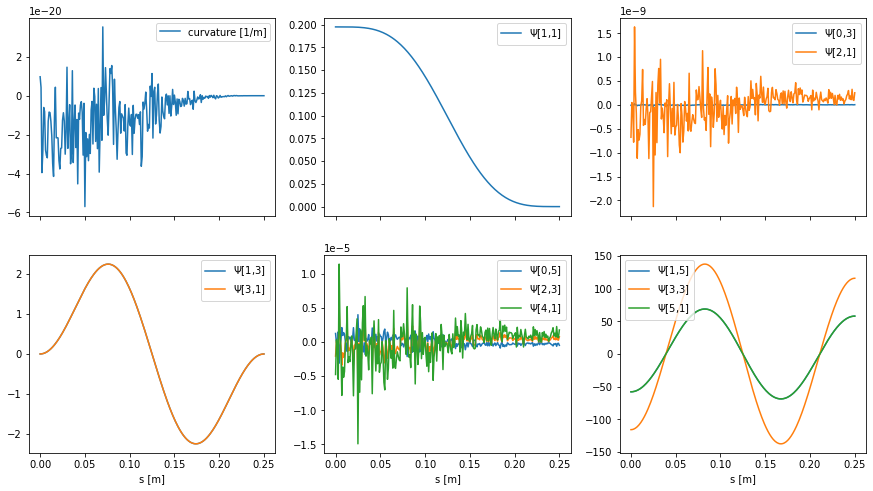

In [19]:
# this just plots the coefs array for each column n, coefs[:,n],
# gets q and q from pqr's n row, and groups plots with same order = p+q
fig, ax = plot_multipoles(traj.s, coefs, pqr)

# upper left plot is not filled yet. insert curvature
ax[0,0].plot(traj.s, traj.curv, label='curvature [1/m]')
ax[0,0].legend()
[a.set_xlabel('s [m]') for a in ax[1]]

In [20]:
# export plots for poster
fig.tight_layout()
fig.savefig(f'{dataset}_extended.pdf')

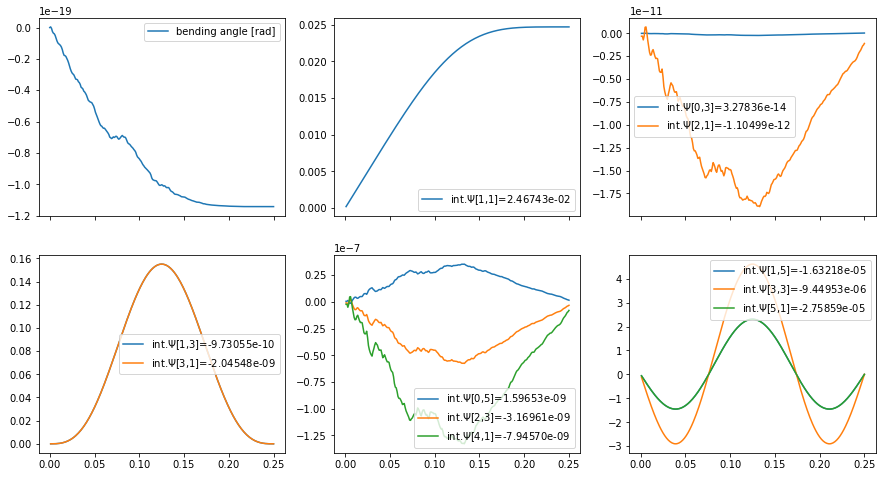

In [21]:
from numpy import rad2deg
fig, ax = plot_multipoles(traj.s, coefs, pqr, integrated=True)
ax[0,0].plot(traj.s, rad2deg(traj.cTheta), label='bending angle [rad]')
ax[0,0].legend()

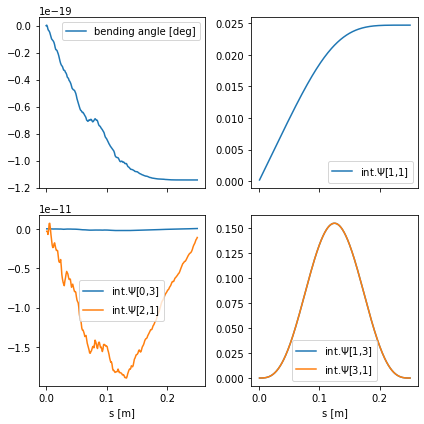

In [22]:
# these are the plots for the paper
fig, ax = subplots(2,2,sharex=True,figsize=(6,6))
plot_multipoles(traj.s, coefs, pqr, axo=ax, integrated=True, numvalues=False)
ax[0,0].plot(traj.s, rad2deg(traj.cTheta), label='bending angle [deg]')
ax[0,0].legend()
[a.set_xlabel('s [m]') for a in ax[1]]
fig.tight_layout()
fig.savefig(f'{dataset}.pdf')